In [1]:
import csv, sqlite3

# define sql database and cursor
con = sqlite3.connect(":memory:")
cur = con.cursor()

# create tables
cur.execute("CREATE TABLE rankings (position int, team text, ranking real);")
cur.execute("CREATE TABLE groups (team text, grp text);")
# insert rankings data
with open('fifa_world_ranking_men_2022.csv','r') as fin:
    dr = csv.DictReader(fin, delimiter=';')
    to_db = [(i['position'], i['team'], i['ranking']) for i in dr]
cur.executemany("INSERT INTO rankings (position, team, ranking) VALUES (?, ?, ?);", to_db)
# insert group data
with open('fifa_world_cup_groups_2022.csv','r') as fin:
    dr = csv.DictReader(fin, delimiter=';')
    to_db = [(i['team'], i['group']) for i in dr]
cur.executemany("INSERT INTO groups (team, grp) VALUES (?, ?);", to_db)

# combine tables for world cup 22 teams
cur.execute('CREATE TABLE teams22 AS SELECT t1.team, t1.grp, t2.position, t2.ranking, 0 AS points FROM groups t1 LEFT JOIN rankings t2 ON t1.team=t2.team')
con.commit()

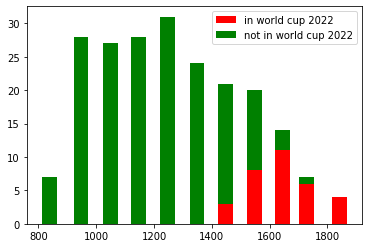

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations 

# ranking histogram

# get counts of team ranks
cur.execute('''
    SELECT t1.ranking, sum(CASE WHEN t2.team IS NOT NULL THEN 1 ELSE 0 END), 
    sum(CASE WHEN t2.team IS NULL THEN 1 ELSE 0 END) 
    FROM rankings t1 LEFT JOIN teams22 t2 ON t2.team=t1.team GROUP BY ROUND(t1.ranking/100)
    ''') 
data = np.array(cur.fetchall()).astype('int')
ranks = data[:, 0]
counts1 = data[:, 1]
counts2 = data[:, 2]

# plot ranking histogram
plt.bar(ranks, counts1, width=50,label='in world cup 2022', color='red')
plt.bar(ranks, counts2, width=50, bottom=counts1, label='not in world cup 2022', color='green')
plt.legend()
plt.show()

In [ ]:
# deterministic tournament simulation

# get rankings
cur.execute('SELECT team, ranking FROM teams22')
data = cur.fetchall()
rankings = {}
for row in data:
    rankings[row[0]] = row[1]

# play group games
cur.execute('SELECT DISTINCT grp FROM teams22')
groups = np.array(cur.fetchall())[:, 0]
for group in groups:
    cur.execute('''
        SELECT team FROM teams22 WHERE grp='{}'
        '''.format(group))
    teams = np.array(cur.fetchall())[:, 0]
    for pair in combinations(teams, 2):
        winner = pair[0] if rankings[pair[0]] > rankings[pair[1]] else pair[1]

        cur.execute('''
        UPDATE teams22 SET points=points + 3 WHERE team='{}'
        '''.format(winner))
        con.commit()

# define gorup results
pos = {}
for group in groups:
    cur.execute('''SELECT team FROM teams22 WHERE grp='{}' ORDER BY points DESC, ranking DESC'''.format(group))
    results = cur.fetchall()
    pos['1'+group] = results[0][0]
    pos['2'+group] = results[1][0]
    pos['3'+group] = results[2][0]
    pos['4'+group] = results[3][0]

# set round of 16
r16 = []
r16.append( (pos['1A'],  pos['2B']) )
r16.append( (pos['1C'],  pos['2D']) )
r16.append( (pos['1E'],  pos['2F']) )
r16.append( (pos['1G'],  pos['2H']) )
r16.append( (pos['1B'],  pos['2A']) )
r16.append( (pos['1D'],  pos['2C']) )
r16.append( (pos['1F'],  pos['2E']) )
r16.append( (pos['1H'],  pos['2G']) )
# play round of 16
r16_winners = []
for pair in r16:
    winner = pair[0] if rankings[pair[0]] > rankings[pair[1]] else pair[1]
    r16_winners.append(winner)

# set quarter final
quarter = []
quarter.append( (r16_winners[0], r16_winners[1]) )
quarter.append( (r16_winners[2], r16_winners[3]) )
quarter.append( (r16_winners[4], r16_winners[5]) )
quarter.append( (r16_winners[6], r16_winners[7]) )
# play quarter final
quarter_winners = []
for pair in quarter:
    winner = pair[0] if rankings[pair[0]] > rankings[pair[1]] else pair[1]
    quarter_winners.append(winner)

# set semi-final
sf = []
sf.append( (quarter_winners[0], quarter_winners[1]) )
sf.append( (quarter_winners[2], quarter_winners[3]) )
# play semi-final
sf_winners = []
sf_losers = []
for pair in sf:
    if rankings[pair[0]] > rankings[pair[1]]:
        winner = pair[0] 
        loser = pair[1]  
    else:
        winner = pair[1]
        loser = pair[0] 
    sf_winners.append(winner)
    sf_losers.append(loser)

# set bronze match
pair = (sf_losers[0], sf_losers[1])
# play bronze match
if rankings[pair[0]] > rankings[pair[1]]:
    winner = pair[0] 
    loser = pair[1]  
else:
    winner = pair[1]
    loser = pair[0]
print('bronze:', winner)

# set final
pair = (sf_winners[0], sf_winners[1])
# play final
if rankings[pair[0]] > rankings[pair[1]]:
    winner = pair[0] 
    loser = pair[1]  
else:
    winner = pair[1]
    loser = pair[0] 

print('gold: ', winner)
print('silver: ', loser)